In [1]:
#
# importing the necessary libraries: 
# NumPy, SciPy (spatial algorithms), timing functions, a handler for csv files 
#
import numpy as np
import scipy.spatial as sp
import time
import csv

In [2]:
#
# Centering a point cloud A
#
def barycentered(A):
    #
    bar = np.sum(A, axis=1)/A.shape[1]
    #
    return A - bar[:, np.newaxis]

In [3]:
#
# Best orthogonal fit between two (centred) labelled point clouds
#
# A and B are assumed to have the same number of points
#
def best_fit(A, B):
    #
    na = A.shape[1]
    nb = B.shape[1]
    #
    assert na==nb
    #
    H = A @ B.T
    W, S, V = np.linalg.svd(H)
    #
    return V.T @ W.T

In [4]:
#
# Detecting nearest neighbours between two unlabelled point coluds A and B
#
# Assumption: cardinality of A <= cardinality of B 
#
# Input: point clouds A, B
#
# Output: for each point of A a matching point of B, as a 0/1-matrix
#
def nearest_neighbours(A, B):
    #
    na = A.shape[1]
    nb = B.shape[1]
    #
    assert na <= nb
    #
    tree = sp.KDTree(A.T, leafsize=10, compact_nodes=True, copy_data=True, balanced_tree=True)
    #
    matching = []
    I = matrix.identity(na)
    #
    for i in range(nb):
        _, ind = tree.query(B.T[i], k=1, p=2, workers=-1)
        matching += [I[ind]]
    #    
    return np.array(matching)

In [5]:
#
# ICP algorithm for two unlabelled point clouds A and B
#
# Assumption: cardinality of A <= cardinality of B
#
# Input:
# A, B = unlabelled point clouds
# init = initial orthogonal transformation
# max_iter = maximum number of iterations
# tol = tolerance for halting the computation
#
# Output:
# U = orthogonal transformation bringing A to B as close as possible
# nn = nearest neighbor matching between U*A and B
# dist = distance between U*A and B*nn (in the max singular value norm)
#
def icp(A, B, init=None, max_iter=100, tol=1e-16):
    #
    src = copy(A)
    dst = copy(B)
    #
    na = src.shape[1]
    nb = src.shape[1]
    #
    assert na <= nb
    #
    if (init is not None):
        src = init @ src
    #    
    prev_err = 0
    #
    for i in range(max_iter):
        #   
        nn = nearest_neighbours(src, dst)
        U = best_fit(src, dst @ nn)
        #    
        src = U @ src
        #
        diff = src - dst @ nn
        err  = np.linalg.norm(diff, 2)
        #
        if abs(prev_err - err) < tol:
            break
        #    
        prev_err = err
    #
    U = best_fit(A, src)
    nn = nearest_neighbours(U @ A, dst)
    #
    diff = U @ A - B @ nn
    dist = np.linalg.norm(diff, 2)
    #
    return U, nn, dist

In [6]:
#
# Testing the Main Algorithm on the Caerbannog point clouds with 
# *multiplicative* noise generated by the Gaussian N(1, \sigma^2)
#

In [7]:
#
# Raghupathi, Sunand; Brunhart-Lupo, Nicholas; Gruchalla, Kenny (2020)
# "Caerbannog Point Clouds". National Renewable Energy Laboratory. 10.7799/1729892
# Source: https://data.nrel.gov/submissions/153
#

In [8]:
#
# Testing the Algorithm on a given point cloud P
# 
# Producing another point cloud Q0 = O * P * S, with O a random orthogonal transformation
# and S a random permutation. Then adding noise N with each entry being Gaussian with
# mean 0 and standard deviation sigma. Creating Q = Q0 (Hadamard product) N.
#
# Test: determine the distance dist_spec from the recovered image of P denoted by 
# R = o * P * S to the specimen Q0, and compare it to the distance between d_icp 
# between o * P * s and Q returned by the ICP algorithm.
#
# Here it is important to note that S is a permutation, while s is a matching of nearest 
# neighbours in o * P and Q. The latter does not have to be a permutation matrix. 
#
def test_point_cloud(P, sigma=0.05, tol=0.05, verbose=False):
    #
    dim = P.shape[0]
    num = P.shape[1]
    normP = np.linalg.norm(P, 2)
    if verbose:
        print("Number of points: {}".format(num))
    #
    seed = np.random.normal(0.0, 1.0, (dim, dim))
    O = np.linalg.qr(seed, mode='complete')[0]
    #
    S = np.random.default_rng().permutation(np.identity(num))
    #
    P = barycentered(P)
    #
    Q0 = O @ P @ S
    N = np.random.normal(1.0, sigma, (dim, num))
    Q = Q0 * N
    diff = Q - Q0
    dist_noise = np.linalg.norm(diff, 2) / normP
    if verbose:
        print("Noise introduced (normalised): {}".format(dist_noise))
    #
    Q = barycentered(Q)
    #
    Ep = P @ P.T
    Eigp, Up = np.linalg.eigh(Ep)
    #
    Eq = Q @ Q.T
    Eigq, Uq = np.linalg.eigh(Eq)
    #
    U0 = Uq @ Up.T
    #
    isoms_discrete = MatrixGroup([matrix.diagonal(d) for d in Permutations([-1]+[1]*(dim-1))])
    isoms_discrete = [np.array(matrix(m)) for m in isoms_discrete]
    #
    sols = []
    for isom in isoms_discrete:
        U = U0 @ Up @ isom @ Up.T
        nn = nearest_neighbours(U @ P, Q)
        diff_init = U @ P - Q @ nn
        d_init = np.linalg.norm(diff_init, 2) / normP
        sols += [(U, nn, d_init)]
    sols = sorted(sols, key=lambda x: x[2])
    o_init, s_init, dist_init = sols[0]
    o, s, d = icp(P, Q, o_init)
    dist_icp = d / normP
    delta_icp = dist_init - dist_icp
    diff = o_init - o
    delta_ortho_icp = np.linalg.norm(diff, 2)
    R = o @ P @ S
    diff = Q0 - R
    dist_spec = np.linalg.norm(diff, 2) / normP
    diff = o - O
    dist_ortho = np.linalg.norm(diff, 2)
    diff = s.T - S
    dist_per = np.linalg.norm(diff, 'fro')**2/(2*num)
    if verbose:
        print("Orthogonal transformation found:")
        print(o)
        print("Distance to the initial one:")
        print(dist_ortho)
        print("Nearest neighbour matching found:")
        print(s.T)
        print("Normalised Hamming distance to the initial permutation:")
        print(dist_per)
        print("Normalised distance to noisy image:")
        print(dist_icp)
        print("Actual distance to specimen (normalised):")
        print(dist_spec)
        print("ICP improvement (normalised):")
        print(delta_icp)
        print("ICP change to orthogonal transformation:")
        print(delta_ortho_icp)
    #
    flag = ( dist_spec < tol )
    #
    return flag, dist_noise, dist_icp, delta_icp, delta_ortho_icp,\
           dist_spec, dist_ortho, dist_per

In [9]:
#
# Running a given number of tests num_tests on a given point cloud
# generated by calling test_point_cloud(P, sigma, tol, verbose)
#
# Some statistics is collected and printed as output
#
def run_tests_point_cloud(P, num_tests, sigma=0.05, tol=0.05, verbose=False):
    #
    num_success = 0
    num_fail  = 0
    rec_dist_noise = []
    rec_dist_icp = []
    rec_delta_icp = []
    rec_delta_ortho_icp = []
    rec_dist_spec = []
    rec_dist_ortho = []
    rec_dist_per = []
    #
    start = time.process_time()
    #
    for i in range(num_tests):
        #
        msg = '### Test #{} : '.format(i+1)
        if verbose:
            print(msg)
        #
        test_flag, test_dist_noise, test_dist_icp, test_delta_icp,\
        test_delta_ortho_icp, test_dist_spec, test_dist_ortho,\
        test_dist_per = test_point_cloud(P, sigma, tol, verbose)
        #
        rec_dist_noise += [test_dist_noise]
        rec_dist_icp += [test_dist_icp]
        rec_delta_icp += [test_delta_icp]
        rec_delta_ortho_icp += [test_delta_ortho_icp]
        rec_dist_spec += [test_dist_spec]
        rec_dist_ortho += [test_dist_ortho]
        rec_dist_per += [test_dist_per]
        #
        if test_flag:
            num_success += 1
        else:
            num_fail += 1
        #
        msg = msg + ' SUCCESS {}'.format(num_success)
        msg = msg + ' FAIL {}'.format(num_fail)
        print(msg, end='\r')
    #
    end = time.process_time()
    #
    assert (num_success + num_fail == num_tests)
    #
    avg_dist_noise = np.mean(rec_dist_noise)
    avg_dist_icp = np.mean(rec_dist_icp)
    avg_delta_icp = np.mean(rec_delta_icp)
    avg_delta_ortho_icp = np.mean(rec_delta_ortho_icp)
    avg_dist_spec = np.mean(rec_dist_spec)
    avg_dist_ortho = np.mean(rec_dist_ortho)
    avg_dist_per = np.mean(rec_dist_per)
    #
    print("Time elapsed:", time.strftime('%H:%M:%S', time.gmtime(end-start)), ' '*42)
    print("Success rate:", float(num_success/num_tests))
    print("======= Mean values =======")
    print("Added noise (normalised): {}".format(avg_dist_noise))
    print("Distance to noisy image (normalised): {}".format(avg_dist_icp))
    print("Distance to specimen (normalised): {}".format(avg_dist_spec))
    print("Distance to initial orthogonal transformation: {}".format(avg_dist_ortho))
    print("Hamming distance to initial permutation (normalised): {}".format(avg_dist_per))
    print("ICP improvement (normalised): {}".format(avg_delta_icp))
    print("ICP change to orthogonal transformation: {}".format(avg_delta_ortho_icp))

In [10]:
#
# The following unoclluded point clouds are used: teapot, bunny, cow. 
#
# The multiplicative noise used is Gaussian N(1, 0.1) in which case most tests pass. 
#
#
filenames = ["Teapot.csv", "Bunny.csv", "Cow.csv"]
#
for name in filenames:
    #
    P = []
    #
    f = open(name)
    reader = csv.reader(f)
    #
    for line in reader:
        P += [[RDF(v) for v in line]]
    #   
    f.close()
    #    
    P = np.array(P).T
    #
    print("File read: {}".format(name))
    #
    run_tests_point_cloud(P, sigma=0.1, num_tests=100, tol=0.05, verbose=False)
    #
    print("#"*42)

File read: Teapot.csv
Time elapsed: 00:04:26                                           
Success rate: 1.0
======= Mean values =======
Added noise (normalised): 0.09040022785753622
Distance to noisy image (normalised): 0.7789756993869966
Distance to specimen (normalised): 0.006480880960899013
Distance to initial orthogonal transformation: 0.0073316485616610316
Hamming distance to initial permutation (normalised): 0.31190883190883195
ICP improvement (normalised): -0.0025066665157419676
ICP change to orthogonal transformation: 0.015815443069448532
##########################################
File read: Bunny.csv
Time elapsed: 00:10:18                                           
Success rate: 1.0
======= Mean values =======
Added noise (normalised): 0.09118708261824626
Distance to noisy image (normalised): 0.7748130662621762
Distance to specimen (normalised): 0.0058340230199550105
Distance to initial orthogonal transformation: 0.006607955397321619
Hamming distance to initial permutation (norm

In [11]:
#
# The following unoclluded point clouds are used: teapot, bunny, cow. 
#
# The multiplicative noise used is Gaussian N(1, 0.6) in which case most tests fail. 
#
#
filenames = ["Teapot.csv", "Bunny.csv", "Cow.csv"]
#
for name in filenames:
    #
    P = []
    #
    f = open(name)
    reader = csv.reader(f)
    #
    for line in reader:
        P += [[RDF(v) for v in line]]
    #   
    f.close()
    #    
    P = np.array(P).T
    #
    print("File read: {}".format(name))
    #
    run_tests_point_cloud(P, sigma=0.6, num_tests=100, tol=0.05, verbose=False)
    #
    print("#"*42)

File read: Teapot.csv
Time elapsed: 00:08:53                                           
Success rate: 0.07
======= Mean values =======
Added noise (normalised): 0.5358099740899163
Distance to noisy image (normalised): 1.6466513647225396
Distance to specimen (normalised): 0.9838236694973177
Distance to initial orthogonal transformation: 1.2489568978427077
Hamming distance to initial permutation (normalised): 0.959088319088319
ICP improvement (normalised): -0.12559322186081284
ICP change to orthogonal transformation: 0.23517617617625577
##########################################
File read: Bunny.csv
Time elapsed: 00:22:44                                           
Success rate: 0.07
======= Mean values =======
Added noise (normalised): 0.5458035724794403
Distance to noisy image (normalised): 1.6125537380728159
Distance to specimen (normalised): 0.9937010161094771
Distance to initial orthogonal transformation: 1.1732413118124922
Hamming distance to initial permutation (normalised): 0.9653

In [12]:
#
# Running a given number of tests num_tests on a given point cloud
#
# Output is then used to plot graphs of test stats
#
def point_cloud_stats(P, num_tests, sigma=0.01, tol=0.05):
    #
    num_success = 0
    num_fail  = 0
    rec_dist_noise = []
    rec_dist_icp = []
    rec_delta_icp = []
    rec_delta_ortho_icp = []
    rec_dist_spec = []
    rec_dist_ortho = []
    rec_dist_per = []
    #
    start = time.process_time()
    #
    for i in range(num_tests):
        test_flag = False
        #
        test_flag, test_dist_noise, test_dist_icp, test_delta_icp,\
        test_delta_ortho_icp, test_dist_spec, test_dist_ortho,\
        test_dist_per = test_point_cloud(P, sigma, tol, verbose=False)
        #
        rec_dist_noise += [test_dist_noise]
        rec_dist_icp += [test_dist_icp]
        rec_delta_icp += [test_delta_icp]
        rec_delta_ortho_icp += [test_delta_ortho_icp]
        rec_dist_spec += [test_dist_spec]
        rec_dist_ortho += [test_dist_ortho]
        rec_dist_per += [test_dist_per]
        if test_flag:
            num_success += 1
        else:
            num_fail += 1
    #
    end = time.process_time()
    #
    assert (num_success + num_fail == num_tests)
    #
    success_rate = float(num_success/num_tests)
    avg_dist_noise = np.mean(rec_dist_noise)
    avg_dist_icp = np.mean(rec_dist_icp)
    avg_delta_icp = np.mean(rec_delta_icp)
    avg_delta_ortho_icp = np.mean(rec_delta_ortho_icp)
    avg_dist_spec = np.mean(rec_dist_spec)
    avg_dist_ortho = np.mean(rec_dist_ortho)
    avg_dist_per = np.mean(rec_dist_per)
    #
    return success_rate, avg_dist_noise, avg_dist_icp, avg_delta_icp, avg_delta_ortho_icp,\
           avg_dist_spec, avg_dist_ortho, avg_dist_per

In [13]:
#
# Produces data for plotting test stats
#
def plot_point_cloud_stats(P, num_tests, sigma_array, tol=0.05):
    stats = []
    for sigma in sigma_array:
        test_stats = point_cloud_stats(P, num_tests, sigma, tol)
        test_stats = (sigma,) + test_stats
        stats += [test_stats]
    return stats 

In [14]:
#
# The following unoclluded point clouds are used: teapot, bunny, cow. 
#
# The multiplicative noise used is Gaussian N(1, \sigma^2) with \sigma 
# taking consecutive values in [0.1, 0.2, ..., 0.6]. 
#
#
filenames = ["Teapot.csv", "Bunny.csv", "Cow.csv"]
data = []
#
for name in filenames:
    #
    P = []
    #
    f = open(name)
    reader = csv.reader(f)
    #
    for line in reader:
        P += [[RDF(v) for v in line]]
    #   
    f.close()
    #    
    P = np.array(P).T
    #
    print("File read: {}".format(name))
    #
    plt = plot_point_cloud_stats(P, num_tests=100, sigma_array=np.arange(0.1,0.7,0.1), tol=0.05)
    data += [(name, plt)]
    #
    print("Test stats produced ...")

File read: Teapot.csv
Test stats produced ...
File read: Bunny.csv
Test stats produced ...
File read: Cow.csv
Test stats produced ...


In [15]:
#
# Test stats prduced have the following structure:
#
# data[_][0] : cloud file name = Teapot.csv, Bunny.csv, or Cow.csv
#
# data[_][1] = stats : test stats where stats[i] stands for
#
# i=0: sigma,
# i=1: success_rate, 
# i=2: avg_dist_noise, 
# i=3: avg_dist_icp, 
# i=4: avg_delta_icp, 
# i=5: avg_delta_ortho_icp,
# i=6: avg_dist_spec, 
# i=7: avg_dist_ortho, 
# i=8: avg_dist_per
#

Teapot.csv
Bunny.csv
Cow.csv


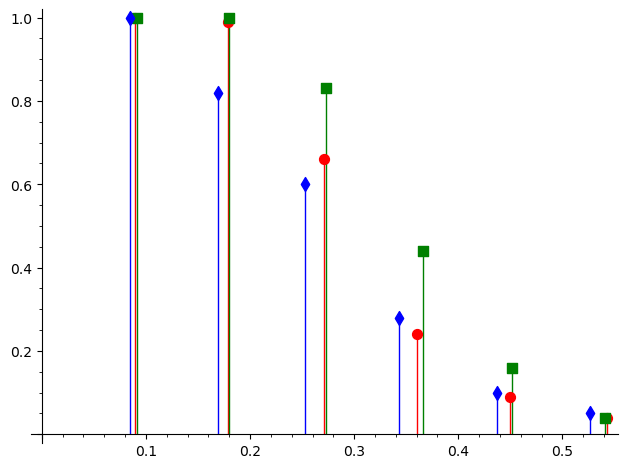

In [16]:
#
# success rate depending on (normalised) noise added
#
# Teapot = circle / red
# Bunny = square / green
# Cow = lozenge / blue
#
img = []
for entry in zip(data, [('o', 'red'), ('s', 'green'), ('d', 'blue')]):
    pic, mark = entry
    print(pic[0])
    stats = pic[1]
    img += [scatter_plot([(s[2],s[1]) for s in stats], marker=mark[0], markersize=50, facecolor=mark[1], edgecolor=None, xmin=0.0, ymin=0)]
    img += [polygon([(s[2],0.0), (s[2],s[1])], color=mark[1], thickness=1, xmin=0.0, ymin=0) for s in stats]
img = sum(img)
img.set_aspect_ratio('automatic')
img.plot().show()

Teapot.csv
Bunny.csv
Cow.csv


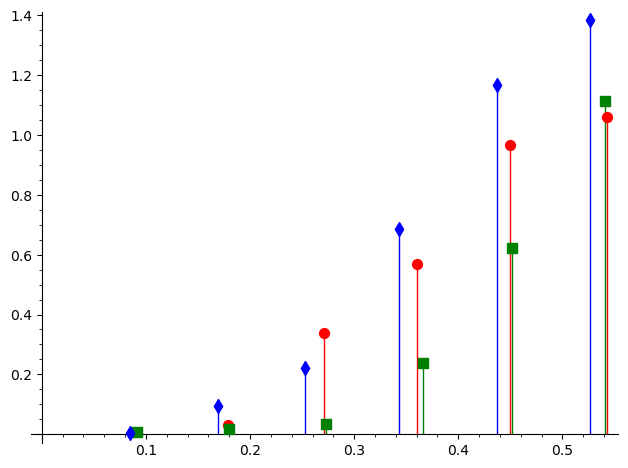

In [17]:
#
# distance to specimen depending on (normalised) noise added
#
# Teapot = circle / red
# Bunny = square / green
# Cow = lozenge / blue
#
img = []
for entry in zip(data, [('o', 'red'), ('s', 'green'), ('d', 'blue')]):
    pic, mark = entry
    print(pic[0])
    stats = pic[1]
    img += [scatter_plot([(s[2],s[6]) for s in stats], marker=mark[0], markersize=50, facecolor=mark[1], edgecolor=None, xmin=0.0, ymin=0)]
    img += [polygon([(s[2],0.0), (s[2],s[6])], color=mark[1], thickness=1, xmin=0.0, ymin=0) for s in stats]
img = sum(img)
img.set_aspect_ratio('automatic')
img.plot().show()

Teapot.csv
Bunny.csv
Cow.csv


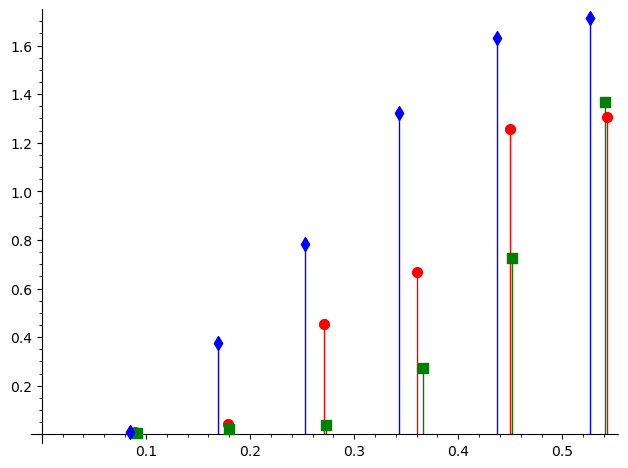

In [18]:
#
# distance to initial orthogonal transformation depending on (normalised) noise added
#
# Teapot = circle / red
# Bunny = square / green
# Cow = lozenge / blue
#
img = []
for entry in zip(data, [('o', 'red'), ('s', 'green'), ('d', 'blue')]):
    pic, mark = entry
    print(pic[0])
    stats = pic[1]
    img += [scatter_plot([(s[2],s[7]) for s in stats], marker=mark[0], markersize=50, facecolor=mark[1], edgecolor=None, xmin=0.0, ymin=0)]
    img += [polygon([(s[2],0.0), (s[2],s[7])], color=mark[1], thickness=1, xmin=0.0, ymin=0) for s in stats]
img = sum(img)
img.set_aspect_ratio('automatic')
img.plot().show()